In [1]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import MobileNetV2

2025-07-04 17:37:47.865882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751650668.054595      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751650668.109675      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Xử lí dataset

In [5]:
import os

# Đường dẫn đến các thư mục
input_train = '/kaggle/input/datasetcanhan/dataset_canhan'

# Đếm số ảnh trong thư mục training
real_train_count = len(os.listdir(os.path.join(input_train, 'real')))
spoof_train_count = len(os.listdir(os.path.join(input_train, 'spoof')))
total_train_count = real_train_count + spoof_train_count

# In kết quả
print(f"Training set:")
print(f"  Real images: {real_train_count}")
print(f"  Spoof images: {spoof_train_count}")
print(f"  Total images: {total_train_count}")

Training set:
  Real images: 1479
  Spoof images: 1428
  Total images: 2907


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

# Kích thước ảnh và batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Đường dẫn đến thư mục gốc chứa real và spoof
input_dir = '/kaggle/input/datasetcanhan/dataset_canhan'  e

# Tạo ImageDataGenerator cho tập huấn luyện với augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  
)

# Tạo ImageDataGenerator cho tập validation (chỉ rescale)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  
)

# Tạo generator cho tập huấn luyện
train_generator = train_datagen.flow_from_directory(
    input_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training' 
)

# Tạo generator cho tập validation
validation_generator = val_datagen.flow_from_directory(
    input_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'  
)

# In class indices
print("Class indices:", train_generator.class_indices)

# Tính class weights
y_train = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Found 2327 images belonging to 2 classes.
Found 580 images belonging to 2 classes.
Class indices: {'real': 0, 'spoof': 1}
Class weights: {0: 0.9826858108108109, 1: 1.0179352580927383}


## Train model


In [ ]:
base_model = MobileNetV2(include_top=False, weights='/kaggle/input/v2-weight/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5', input_shape=(224, 224, 3))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') 
])


model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

I0000 00:00:1751650684.628148      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751650684.628855      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [ ]:
callbacks = [
    ModelCheckpoint(
        filepath='best_model_retrained.h5',
        monitor='val_loss',  
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=50,  
    verbose=1,
    callbacks=callbacks  
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1751650727.796213      78 service.cc:148] XLA service 0x7b38d01218e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751650727.796892      78 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751650727.796915      78 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751650731.396860      78 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751650751.759570      78 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.7894 - loss: 0.4358
Epoch 1: val_loss improved from inf to 1.56595, saving model to best_model_retrained.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 128s 914ms/step - accuracy: 0.7911 - loss: 0.4329 - val_accuracy: 0.5174 - val_loss: 1.5659 - learning_rate: 1.0000e-04
Epoch 2/50
 1/72 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 0.0236

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 1.56595
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 0.0236 - val_accuracy: 0.5191 - val_loss: 1.5663 - learning_rate: 1.0000e-04
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9968 - loss: 0.0180
Epoch 3: val_loss did not improve from 1.56595
72/72 ━━━━━━━━━━━━━━━━━━━━ 33s 461ms/step - accuracy: 0.9968 - loss: 0.0179 - val_accuracy: 0.5122 - val_loss: 2.8067 - learning_rate: 1.0000e-04
Epoch 4/50
 1/72 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 1.0000 - loss: 0.0080
Epoch 4: val_loss did not improve from 1.56595
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0080 - val_accuracy: 0.5156 - val_loss: 2.7574 - learning_rate: 1.0000e-04
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9880 - loss: 0.0376
Epoch 5: val_loss did not improve from 1.56595
72/72 ━━━━━━━━━━━━━━━━━━━━ 33s 459ms/step - accuracy: 0.9881 - loss: 0.0375 - val_accuracy: 0.5642 - val_loss: 1.6146 - 

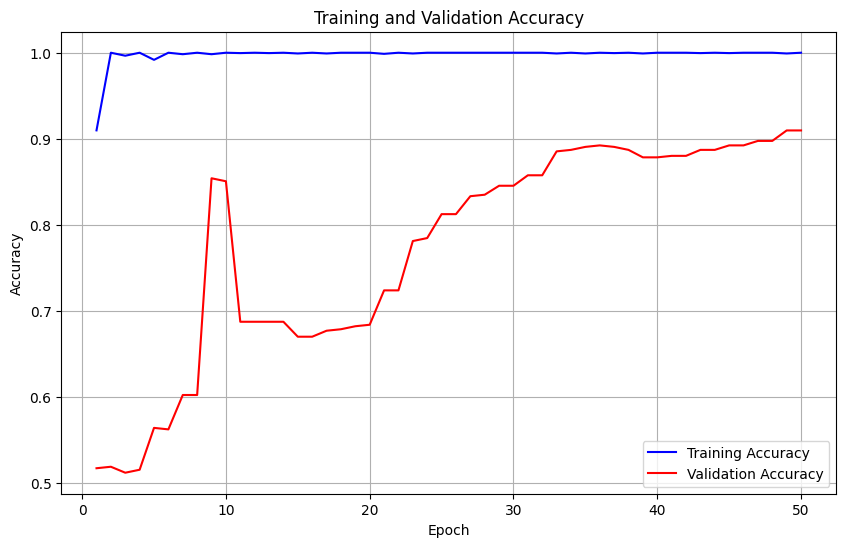

In [ ]:
import matplotlib.pyplot as plt

# Lấy dữ liệu từ history
epochs = range(1, len(history.history['accuracy']) + 1)
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')

# Thêm tiêu đề và nhãn
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Hiển thị lưới
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

## Demo chống giả mạo khuôn mặt bằng hình ảnh, video

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
%pip install mtcnn
from mtcnn import MTCNN
from tensorflow.keras.preprocessing.image import img_to_array


In [ ]:

IMG_HEIGHT, IMG_WIDTH = 224, 224

model = tf.keras.models.load_model('best_model_retrained_1.h5')

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
if face_cascade.empty():
    raise Exception("Không thể tải Haar Cascade!")

# Hàm tiền xử lý ảnh khuôn mặt
def preprocess_face(face_img):
    face_img = cv2.resize(face_img, (IMG_HEIGHT, IMG_WIDTH))
    face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    face_img = img_to_array(face_img) / 255.0
    face_img = np.expand_dims(face_img, axis=0)
    return face_img

# Hàm dự đoán thật/giả
def predict_face(face_img):
    processed_face = preprocess_face(face_img)
    prediction = model.predict(processed_face, verbose=0)[0][0]
    label = 'Fake' if prediction > 0.5 else 'Real'
    confidence = prediction if prediction > 0.5 else 1 - prediction
    return label, confidence

# Hàm xử lý video real-time
def process_video(video_source=0):
    
    cap = cv2.VideoCapture(video_source) 
    if not cap.isOpened():
        print("Không thể mở video/webcam!")
        return
    
    while True:
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1) 
        if not ret:
            print("Không thể đọc khung hình!")
            break
            
        # Chuyển sang ảnh xám để phát hiện khuôn mặt
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        
        # Xử lý từng khuôn mặt
        for (x, y, w, h) in faces:
            face_img = frame[max(0, y):y+h, max(0, x):x+w]
            
            try:
                label, confidence = predict_face(face_img)
                color = (0, 0, 255) if label == 'Fake' else (0, 255, 0)
                cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
                cv2.putText(frame, f'{label} ({confidence:.2f})', (x, y-10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
            except Exception as e:
                print(f"Lỗi xử lý khuôn mặt: {e}")
                continue
        
        cv2.imshow('Deepfake Detection', frame)
        
    
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
  
    cap.release()
    cv2.destroyAllWindows()


process_video() 

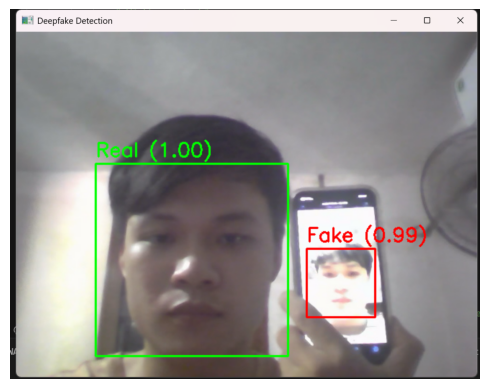

In [5]:
import cv2
import matplotlib.pyplot as plt

# Đọc ảnh bằng OpenCV (ảnh BGR)
img = cv2.imread(r'C:\Users\hn745\Documents\eKYC\Screenshot 2025-07-05 143039.png')

# Chuyển từ BGR sang RGB để hiển thị đúng màu
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Vẽ ảnh
plt.imshow(img_rgb)
plt.axis('off')  
plt.show()
